# Imports

In [17]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models

# Exercise Simple RNN with Pytorch

## Extract Data

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
df = pd.read_csv(url)
print(df.head())

     Month  Sunspots
0  1749-01      58.0
1  1749-02      62.6
2  1749-03      70.0
3  1749-04      55.7
4  1749-05      85.0


## Perform Data transformation

In [ ]:
values = df["Sunspots"].values.astype(float)

def create_dataset(series, lookback=12):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

lookback = 12
X, y = create_dataset(values, lookback)

X = X.reshape(X.shape[0], X.shape[1], 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Implement simple RNN Model

In [8]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        last_output = out[:, -1, :]
        return self.fc(last_output)

model = SimpleRNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [10]:
epochs = 30

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 3036.2051
Epoch 5, Loss: 1797.3761
Epoch 10, Loss: 850.1465
Epoch 15, Loss: 440.5597
Epoch 20, Loss: 658.1280
Epoch 25, Loss: 253.4319


## Evaluation

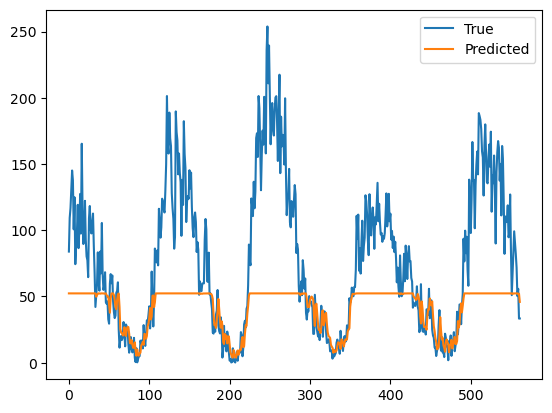

In [11]:
model.eval()
with torch.no_grad():
    pred_test = model(X_test_t).numpy()

import matplotlib.pyplot as plt

plt.plot(y_test, label="True")
plt.plot(pred_test, label="Predicted")
plt.legend()
plt.show()

# With Keras

## Scale Data

In [14]:
scaler = MinMaxScaler()

values_scaled = scaler.fit_transform(values.reshape(-1,1)).flatten()

## Create Lookback sequence

In [ ]:
def create_dataset(series, lookback=12):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

lookback = 12
X, y = create_dataset(values_scaled, lookback)

X = X.reshape((X.shape[0], X.shape[1], 1))

## Train test split

In [16]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Implement model

In [19]:
model = models.Sequential([
    layers.SimpleRNN(
        32, 
        activation="tanh",
        return_sequences=False,
        input_shape=(lookback, 1)   
    ),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

/opt/anaconda3/envs/dl_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633 (6.38 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/30


2025-11-14 11:17:24.036359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 10/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 11/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 12/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0037 - val_l

In [24]:
print(np.sqrt(history.history["loss"]))

[0.08577878 0.06193352 0.06061139 0.06044465 0.06101419 0.06007636
 0.06068135 0.06010681 0.06168833 0.06001597 0.0604841  0.06095298
 0.06257919 0.06108585 0.05996445 0.06313464 0.0624797  0.06254469
 0.0619128  0.06445165 0.06457034 0.06364425 0.06481278 0.06176593
 0.06094664 0.0630408  0.06254865 0.06121274 0.06297653 0.06227506]


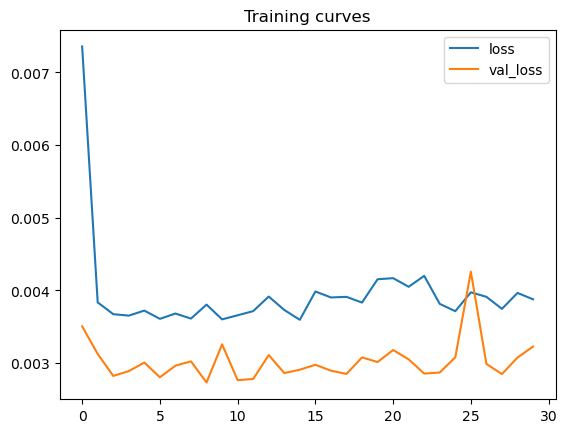

In [25]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Training curves")
plt.show()

## Test

In [ ]:
y_pred = model.predict(X_test)

y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_real = scaler.inverse_transform(y_pred)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
test_mse = model.evaluate(X_test, y_test)

rmse = np.sqrt(test_mse)
print("Test RMSE :", rmse)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0057
Test RMSE : 0.07525990238750965


## Visualize

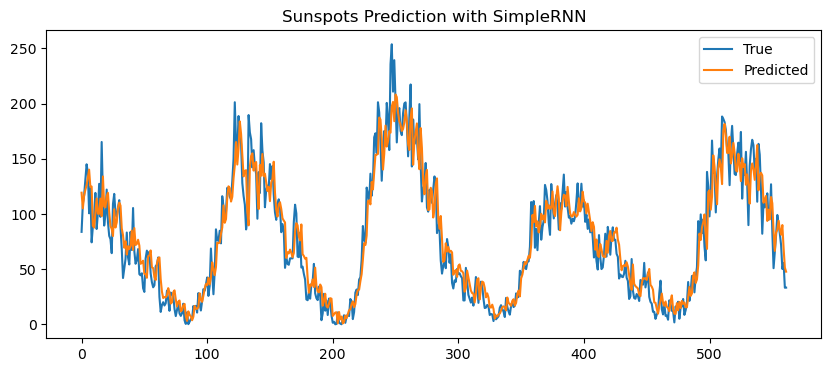

In [22]:
plt.figure(figsize=(10,4))
plt.plot(y_test_real, label="True")
plt.plot(y_pred_real, label="Predicted")
plt.legend()
plt.title("Sunspots Prediction with SimpleRNN")
plt.show()